In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip uninstall keras tensorflow

Found existing installation: keras 2.13.1
Uninstalling keras-2.13.1:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/keras-2.13.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/keras/*
Proceed (Y/n)? 

In [ ]:
!pip install -q tensorflow==2.12.0

In [ ]:
import tensorflow as tf
print(tf.__version__)

In [ ]:
!pip install -q segmentation-models

In [ ]:
# Use the ! (exclamation mark) to run shell commands in Colab
# !unzip /content/drive/MyDrive/archive.zip -d /content/drive/MyDrive/Dataset

In [ ]:
!pip install patchify
# !pip install segmentation_models

In [ ]:
import numpy as np
import pandas as pd

import os

import tensorflow as tf
os.environ["SM_FRAMEWORK"] = "tf.keras"
from tensorflow import keras
import sklearn
import cv2
import matplotlib.pyplot as plt
from platform import  python_version
from glob import glob
from keras import backend as K
from tqdm import tqdm
from PIL import Image

# !pip install patchify
from patchify import patchify
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam

import shutil

# !pip install segmentation-models
import segmentation_models as sm
import warnings
warnings.filterwarnings("ignore")

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

%config Completer.use_jedi = False

sm.set_framework('tf.keras')
sm.framework()

In [ ]:
# import numpy as np
# import pandas as pd
# import os
# import tensorflow as tf
# import cv2
# import matplotlib.pyplot as plt
# from platform import python_version
# from glob import glob
# from tensorflow.keras import backend as K
# from PIL import Image

# # Replace 'import keras' with 'import tensorflow.keras as keras'
# import tensorflow.keras as keras

# # Remove import: from keras.utils import get_custom_objects

# # Your other code...

# # Install and update necessary dependencies
# # !pip install --upgrade tensorflow keras segmentation-models efficientnet

# import segmentation_models as sm
# import warnings
# warnings.filterwarnings("ignore")

# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

# %config Completer.use_jedi = False

# sm.set_framework('tf.keras')
# sm.framework()


In [ ]:
import sys
print("Python version")
print(sys.version)


In [ ]:
base_dir = '/content/drive/MyDrive/Dataset'
print(os.listdir(base_dir))
print("Keras version : " + keras.__version__)
print("Tensorflow version : " + tf.__version__)
print("Python version : " + python_version())
print("Sklearn version : " + sklearn.__version__)
print("CV2 version : " + cv2.__version__)
print("Pandas version : " + pd.__version__)


In [ ]:
filenames = pd.read_csv(os.path.join(base_dir, 'metadata.csv'))
filenames

In [ ]:
print(filenames['split'].value_counts())

In [ ]:
train_df = filenames[filenames['split']=='train']
train_df['sat_image_path'] = train_df['sat_image_path'].apply(lambda img_pth: os.path.join(base_dir, img_pth))
train_df['mask_path'] = train_df['mask_path'].apply(lambda img_pth: os.path.join(base_dir, img_pth))
train_df

In [ ]:
i = np.random.randint(0, len(train_df))
img = cv2.imread(train_df['sat_image_path'].iloc[i])
mask = cv2.imread(train_df['mask_path'].iloc[i])
plt.figure(figsize=(50,50))

plt.subplot(121)
plt.axis('off')
plt.title('Landscape',fontsize=18)
plt.imshow(img)

plt.subplot(122)
plt.axis('off')
plt.title('Gray Mask',fontsize=18 )
plt.imshow(mask)


In [ ]:
class_dict = pd.read_csv(os.path.join(base_dir, 'class_dict.csv'))
num_class = len(class_dict)
print(f'Number of classes {num_class}')
class_dict

In [ ]:
if os.path.exists('masks256') :
    shutil.rmtree('masks256')
if os.path.exists('images256') :
    shutil.rmtree('images256')

os.mkdir('images256')
os.mkdir('masks256')
patch_size =256


def patches(train_df):
    num_of_saved_files = 0
    for img_path, mask_path in tqdm(train_df[['sat_image_path','mask_path']].to_numpy()):
        image = cv2.imread(img_path, 1)
        mask = cv2.imread(mask_path)
        assert image.shape == mask.shape
        SIZE_X = (image.shape[1]//patch_size)*patch_size
        SIZE_Y = (image.shape[0]//patch_size)*patch_size

        image = Image.fromarray(image)
        image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
        image = np.array(image)

        patches_img = patchify(image, (256, 256, 3), step=256)  #Step=256 for 256 patches means no overlap
        patches_mask = patchify(mask, (256, 256, 3), step=256)

        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):

                single_patch_mask = patches_mask[i,j,:,:]
                single_patch_mask = single_patch_mask[0]

                val, counts = np.unique(single_patch_mask, return_counts=True)
                max_counts = np.max(counts)/counts.sum()
                if max_counts < 0.95:
                    single_patch_img = patches_img[i,j,:,:]
                    single_patch_img = single_patch_img[0]

                    cv2.imwrite(f'images256/{num_of_saved_files}.tif', single_patch_img)
                    cv2.imwrite(f'masks256/{num_of_saved_files}.tif', single_patch_mask)
                    num_of_saved_files += 1

In [ ]:
cd /content/drive/MyDrive/Dataset

In [ ]:
ls

In [ ]:
# Run for creating patches 256x256
patches(train_df)

In [ ]:

colors = []
for (r,g,b) in class_dict[['r', 'g', 'b']].to_numpy():
    colors.append([r,g,b])
map_color = {x:v for x,v in zip(range(num_class),colors)}
colors

map_color

In [ ]:
{1:[255, 255,0]}

### Preproccesing

In [ ]:
num_classes =7
def rgb_to_onehot(rgb_arr):
    color_dict= map_color
    num_classes = len(color_dict)
    shape = rgb_arr.shape[:2]+(num_classes,)
    arr = np.zeros( shape, dtype=np.int8 )
    for i, cls_ in enumerate(color_dict):
        arr[:,:,i] = np.all(rgb_arr.reshape( (-1,3) ) == color_dict[i], axis=1).reshape(shape[:2])
    return arr

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

def preprocess_data_rgb_to_onehot(img, mask, num_class=7):
    masks = np.zeros((mask.shape[0], 256, 256,7))
    for i ,m in enumerate(mask):
        masks[i] =rgb_to_onehot(m)
        img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    return (img,masks)

In [ ]:
def onehot_to_rgb(onehot, color_dict= map_color):
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in color_dict.keys():
        output[single_layer==k] = color_dict[k]
    return np.uint8(output)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

seed=24
batch_size= 32
patched_dir = '/content/drive/MyDrive/Dataset'

def data_generator(num_class=7):
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')

    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args )

    validation_split= 0.1

    df_len = len(glob(os.path.join(patched_dir,'images256/*.tif')))
    subset = np.empty(df_len, dtype=object)
    subset[:int((1-validation_split)*df_len)] = 'train'
    subset[int((1-validation_split)*df_len):] = 'valid'
    np.random.shuffle(subset)
    df_filenames = pd.DataFrame(np.vstack((np.sort(np.array((glob(os.path.join(patched_dir,'images256/*.tif')),glob(os.path.join(patched_dir,'masks256/*.tif'))))), subset)).T, columns = ['img', 'masks','subset'])
    df_train = df_filenames[df_filenames.subset  == 'train']
    df_valid = df_filenames[df_filenames.subset  == 'valid']

    image_train_generator = image_datagen.flow_from_dataframe(
        dataframe = df_train,
        train_dir=None,
        x_col="img",
        batch_size= batch_size,
        seed=24,
        class_mode = None)

    mask_train_generator = mask_datagen.flow_from_dataframe(
        dataframe = df_train,
        train_dir=None,
        x_col="masks",
        batch_size= batch_size,
        seed=24,
        class_mode = None)



    mask_valid_generator = image_datagen.flow_from_dataframe(
        dataframe = df_valid,
        train_dir=None,
        x_col="masks",
        batch_size= batch_size,
        seed=24,
        class_mode = None,
        validate_filenames=False)


    image_valid_generator = mask_datagen.flow_from_dataframe(
        dataframe = df_valid,
        train_dir=None,
        x_col="img",
        batch_size= batch_size,
        seed=24,
        class_mode = None,
        validate_filenames=False)

    train_generator= zip(image_train_generator,mask_train_generator)
    valid_generator = zip(image_valid_generator, mask_valid_generator)
    return(train_generator,valid_generator)

def transform_generator(gen):
    for (img, mask) in gen:
        before = (img.shape,mask.shape)
        img, mask = preprocess_data_rgb_to_onehot(img, mask)
        yield (img, mask)

def train_valid_gen(num_class=7):
    train_gen,valid_gen = data_generator(num_class=num_class)
    train_gen = transform_generator(train_gen)
    valid_gen = transform_generator(valid_gen)
    return (train_gen,valid_gen)

In [ ]:
t, v = train_valid_gen()

In [ ]:
%%time
x, y=next(t)

Preprocess_data takes Wall time: 8.82s for batch size = 32

In [ ]:
def one_hot_encode(label):
    label_values = colors
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1).astype('float')

    return semantic_map

In [ ]:
def preprocess_data(imgs, masks):
    return (imgs,one_hot_encode(masks))

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

seed=24
batch_size= 32

patched_dir = '/content/drive/MyDrive/Dataset'

def data_generator(num_class=7):
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')

    image_datagen = ImageDataGenerator(**img_data_gen_args, rescale=1.0/255.0)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)


    validation_split= 0.2

    df_len = len(glob(os.path.join(patched_dir,'images256/*.tif')))
    subset = np.empty(df_len, dtype=object)
    subset[:int((1-validation_split)*df_len)] = 'train'
    subset[int((1-validation_split)*df_len):] = 'valid'
    np.random.shuffle(subset)
    df_filenames = pd.DataFrame(np.vstack((np.sort(np.array((glob(os.path.join(patched_dir,'images256/*.tif')),glob(os.path.join(patched_dir,'masks256/*.tif'))))), subset)).T, columns = ['img', 'masks','subset'])
    df_train = df_filenames[df_filenames.subset  == 'train']
    df_valid = df_filenames[df_filenames.subset  == 'valid']

    image_train_generator = image_datagen.flow_from_dataframe(
        dataframe = df_train,
        train_dir=None,
        x_col="img",
        batch_size= batch_size,
        seed=24,
        class_mode = None)

    mask_train_generator = mask_datagen.flow_from_dataframe(
        dataframe = df_train,
        train_dir=None,
        x_col="masks",
        batch_size= batch_size,
        seed=24,
        class_mode = None)


    mask_valid_generator = mask_datagen.flow_from_dataframe(
        dataframe = df_valid,
        train_dir=None,
        x_col="masks",
        batch_size= batch_size,
        seed=24,
        class_mode = None)


    image_valid_generator = image_datagen.flow_from_dataframe(
        dataframe = df_valid,
        train_dir=None,
        x_col="img",
        batch_size= batch_size,
        seed=24,
        class_mode = None)

    train_generator= zip(image_train_generator,mask_train_generator)
    valid_generator = zip(image_valid_generator, mask_valid_generator)
    return(train_generator,valid_generator)

def transform_generator(gen):
    for (img, mask) in gen:
        img, mask = preprocess_data(img, mask)
        yield (img, mask)

def train_valid_gen(num_class=7):
    train_gen,valid_gen = data_generator(num_class=num_class)
    train_gen = transform_generator(train_gen)
    valid_gen = transform_generator(valid_gen)
    return (train_gen,valid_gen)

In [ ]:
t, v = train_valid_gen()

Found 48984 validated image filenames.
Found 48984 validated image filenames.
Found 12247 validated image filenames.
Found 12247 validated image filenames.


In [ ]:
%%time
x, y=next(t)

CPU times: user 878 ms, sys: 121 ms, total: 998 ms
Wall time: 5.02 s


one_hot_encode reduces Wall time to 1.11 s

### Check generator

In [ ]:
t, v = train_valid_gen()

Found 48984 validated image filenames.
Found 48984 validated image filenames.
Found 12247 validated image filenames.
Found 12247 validated image filenames.


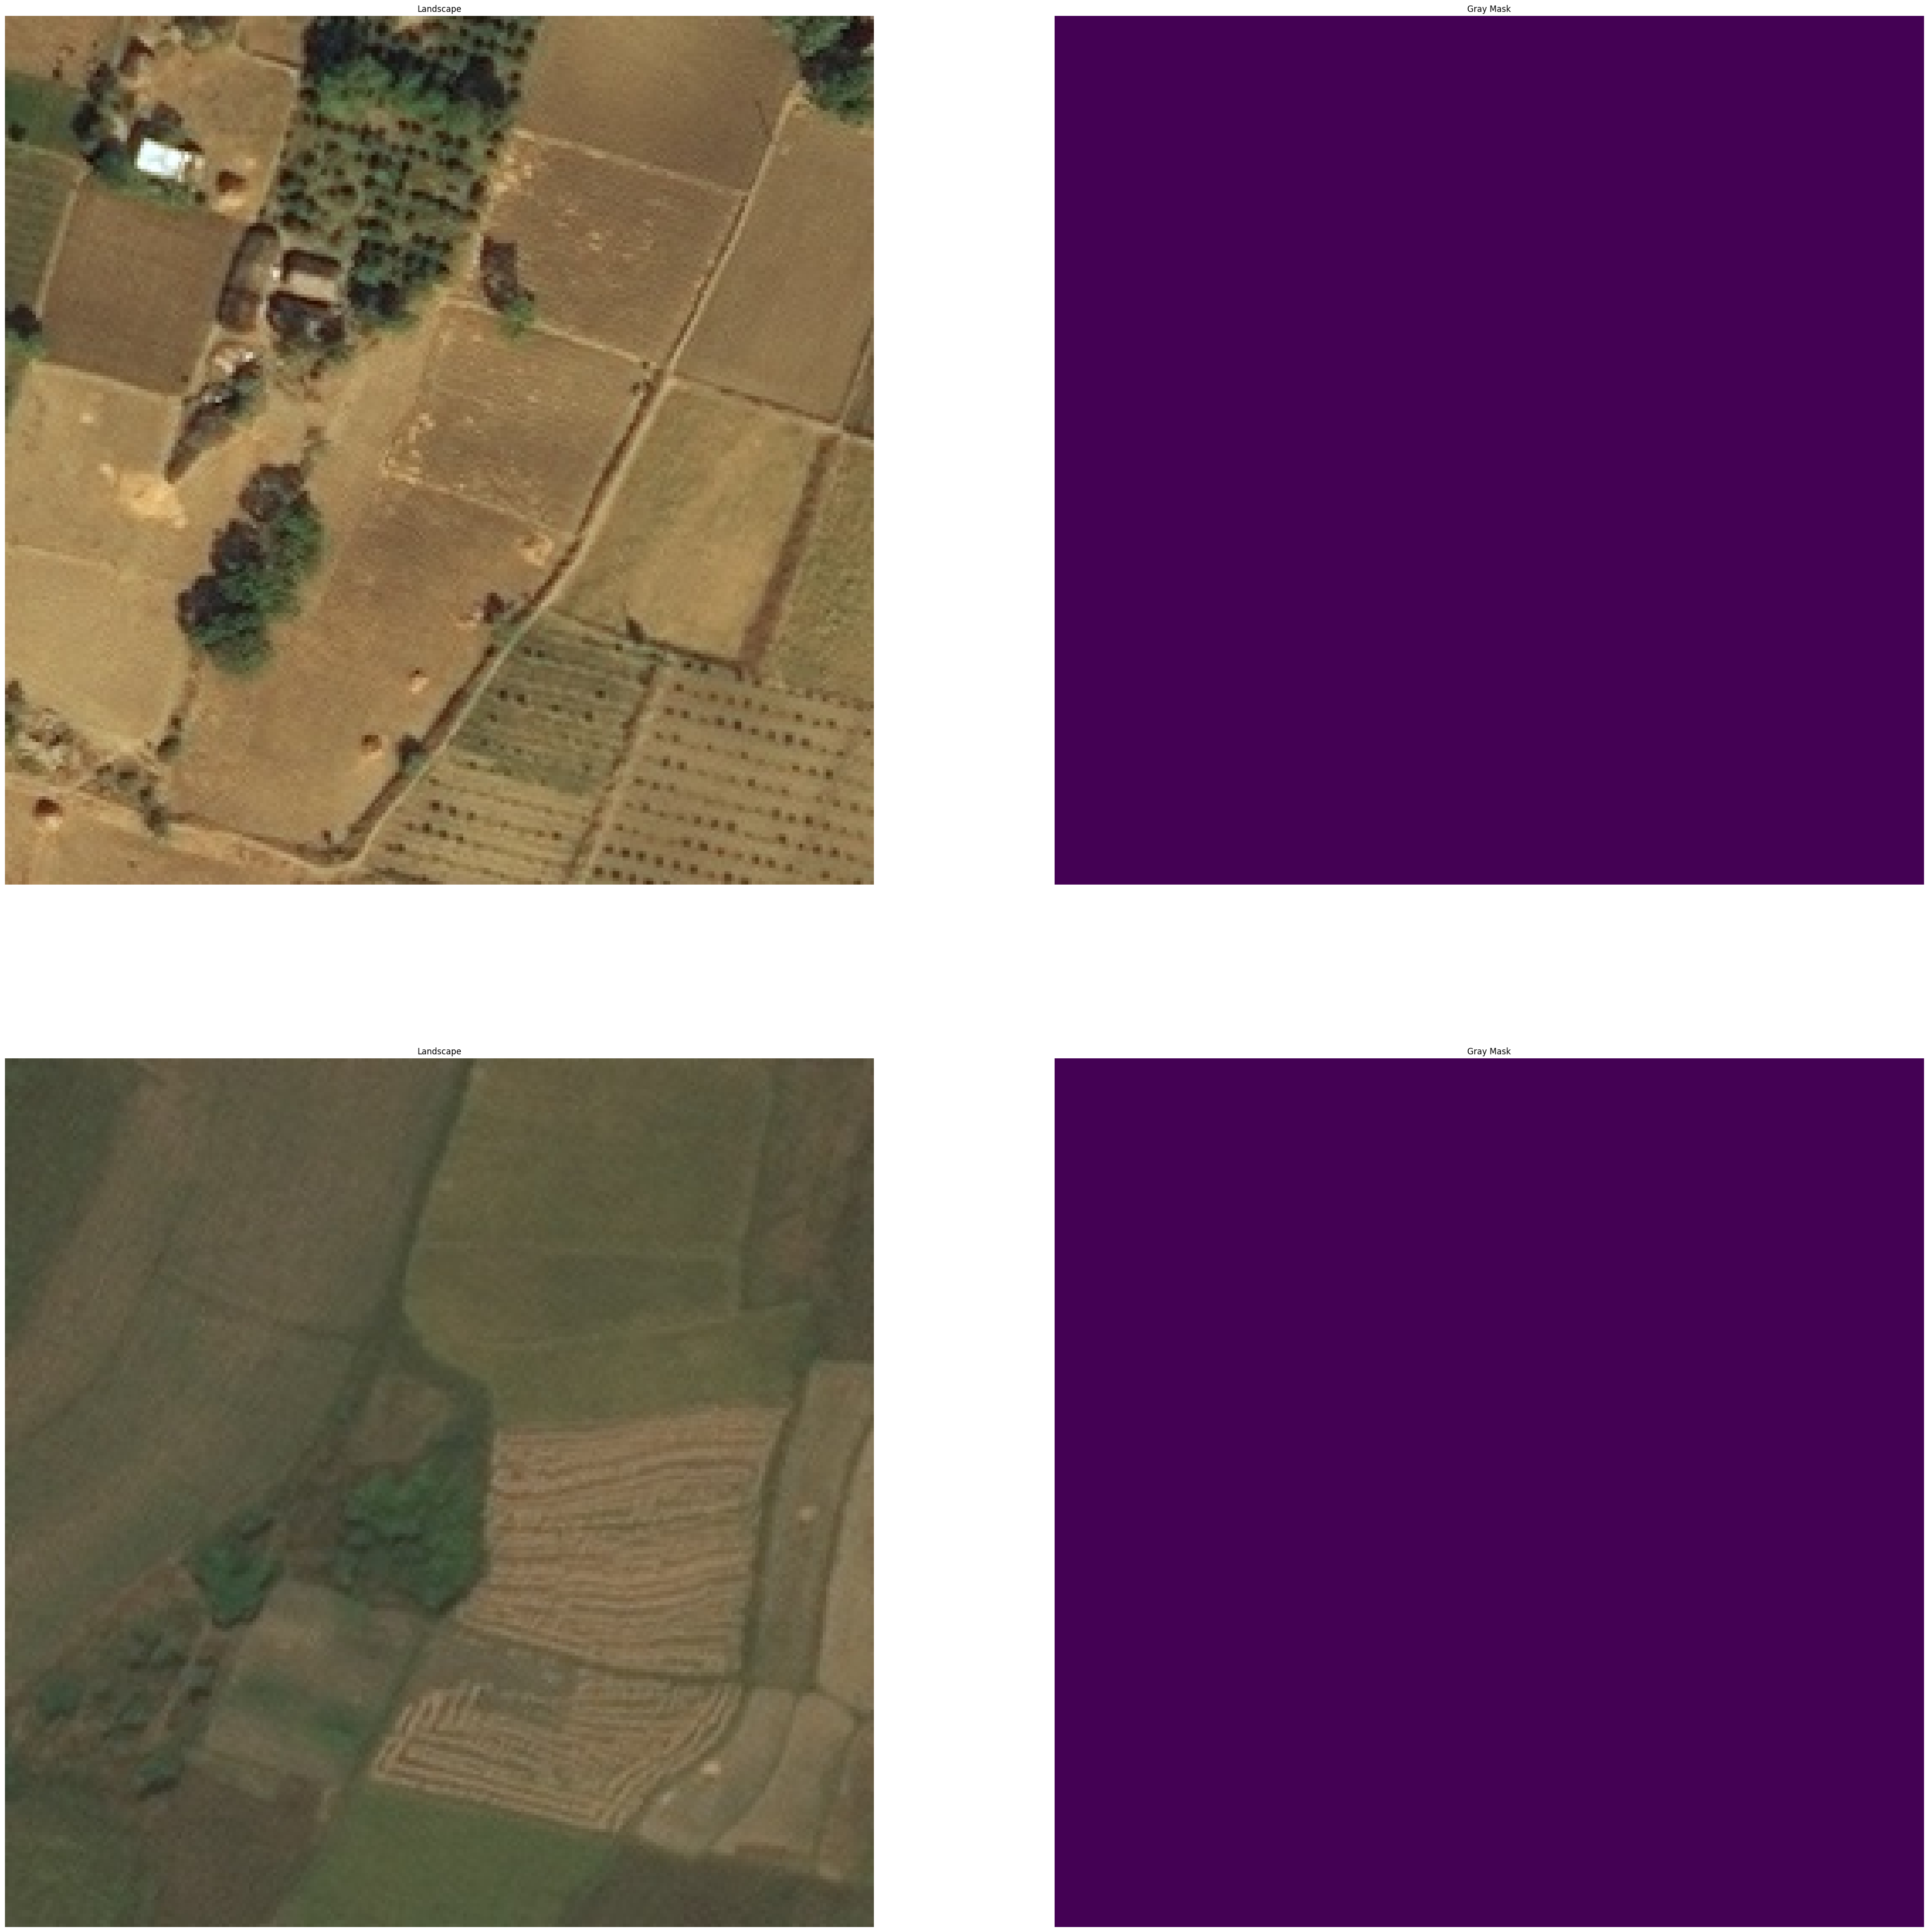

In [ ]:
def check_gens(train_gen, valid_gen):
    x, y = next(train_gen)
    i =8
    plt.figure(figsize = (50,50))
    plt.subplot(221)
    plt.axis('off')
    plt.title('Landscape')
    plt.imshow(x[i])

    plt.subplot(222)
    plt.axis('off')
    plt.title('Gray Mask')
    mask =  cv2.imread('../input/patched/data/masks256/1.tif')
    plt.imshow(np.argmax((y)[i],axis=2)*64)


    x, y = next(valid_gen)
    plt.subplot(223)
    plt.axis('off')
    plt.title('Landscape')
    plt.imshow(x[i])

    plt.subplot(224)
    plt.axis('off')
    plt.title('Gray Mask')
    mask =  cv2.imread('../input/patched/data/masks256/1.tif')
    plt.imshow(np.argmax((y)[i],axis=2)*64)
check_gens(t,v)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

def callback(name):
    checkpoint = ModelCheckpoint("{}.h5".format(name), monitor='val_iou_score', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)
    reduce = ReduceLROnPlateau(monitor='val_iou_score',
                                   patience=2,
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)

    early = EarlyStopping(monitor="val_iou_score",
                      mode="min",
                      patience=2)

    tensorboard = TensorBoard(log_dir="logs/{}".format(name))

    callbacks = [checkpoint, early, reduce,tensorboard]

### Neural network

In [ ]:

def unet(input_size=(256,256,3)):
    inputs = Input(input_size)

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(num_class, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [ ]:
model = unet()
from tensorflow.keras.metrics import MeanIoU
model.compile(optimizer = Adam(lr = 0.0001), loss=sm.losses.categorical_focal_jaccard_loss, metrics=[sm.metrics.iou_score])

In [ ]:
# history = model.fit_generator(train_gen,
#                 steps_per_epoch=2692// batch_size,
#                 epochs=50, validation_data = valid_gen, validation_steps=300//batch_size, callbacks =callbacks)

### U-net using segmentation models

In [ ]:
def u_net_models(backbones):

    metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), 'accuracy']
    histories = {}

    for backbone in backbones:
        callbacks = callback(backbone)

        model = sm.Unet(backbone, encoder_weights='imagenet',
                input_shape=(256,256,3),
                classes=7, activation='softmax')
        model.compile(optimizer = Adam(lr = 0.0001), loss=sm.losses.categorical_focal_jaccard_loss, metrics=metrics)

        train_gen,valid_gen = train_valid_gen(7)
        print('Model : {}'.format(backbone))
        history = model.fit_generator(train_gen,
                steps_per_epoch=2692// batch_size,
                epochs=50, validation_data = valid_gen, validation_steps=300//batch_size, callbacks =callbacks)
        model.save('{}.h5'.format(backbone))
        histories[backbone] = history
    return histories

In [ ]:
backbones = ['resnet34', 'inceptionv3', 'vgg16']

In [ ]:
histories = u_net_models(backbones)

85521592/85521592 [==============================] - 1s 0us/step


Found 48984 validated image filenames.
Found 48984 validated image filenames.
Found 12247 validated image filenames.
Found 12247 validated image filenames.
Model : resnet34
Epoch 1/50
22/84 [======>.......................] - ETA: 3:08 - loss: 0.9038 - iou_score: 0.2281 - f1-score: 0.2848 - accuracy: 0.5012

UnknownError: ignored

In [ ]:
model.save(histories)

In [ ]:
  def predict_image(model, img):
    w,h = img.shape[:2]
    w = w // 256 +1
    h = h // 256 +1
    padding_shape = (w*256,h*256 ,3)
    padded_img= np.zeros(padding_shape)
    mask_shape = (w*256,h*256,7)

    padded_img[0:img.shape[0], 0:img.shape[1], :] = img
    padded_img = padded_img/255
    mask_padded = np.zeros(mask_shape)

    for i in range(0,mask_shape[0], 256):
        for j in range(0, mask_shape[1], 256):
            patch = padded_img[i:i+256,j:j+256,:]
            predicted  = model.predict(np.expand_dims(patch,axis=0))
            mask_padded[i:i+256,j:j+256,:] =predicted
    return mask_padded[0:img.shape[0], 0:img.shape[1], :]

In [ ]:
models_path = ['G:/Major Project/dataset/models/resnet34.h5','G:/Major Project/dataset/models/inceptionv3.h5', 'G:/Major Project/dataset/models/vgg16.h5']


In [ ]:
def predict(img, paths):
    predicted_masks = []
    for path in models_path:
        model = keras.models.load_model(path,
                                        custom_objects={'focal_loss_plus_jaccard_loss': sm.losses.categorical_focal_jaccard_loss,
                                                        'iou_score':sm.metrics.IOUScore,
                                                        'threshold': 0.5,
                                                        'f1-score':sm.metrics.FScore})

        predicted_masks.append(predict_image(model, img))
    return predicted_masks

In [ ]:
img = cv2.imread('../input/dataset/train/10452_sat.jpg')

In [ ]:
predicted_masks = predict(img, models_path)

OSError: ignored

In [ ]:
def plot(predicted_masks):
    plt.figure(figsize=(50,50))
    plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)

    plt.subplot(151)
    plt.title('Original Image' ,fontsize=18)
    plt.axis('off')
    plt.imshow(img)

    plt.subplot(152)
    plt.title('Mask {}'.format(backbones[0]) ,fontsize=18)
    plt.axis('off')
    plt.imshow(onehot_to_rgb(predicted_masks[0]))

    plt.subplot(153)
    plt.title('Mask {}'.format(backbones[1]) ,fontsize=18)
    plt.axis('off')
    plt.imshow(onehot_to_rgb(predicted_masks[1]))

    plt.subplot(154)
    plt.title('Mask {}'.format(backbones[2]) ,fontsize=18)
    plt.axis('off')
    plt.imshow(onehot_to_rgb(predicted_masks[2]))
    plt.savefig('models_masks.jpeg',dpi = 100)
plot(predicted_masks)

NameError: ignored

In [ ]:
img = cv2.imread('G:/Major Project/dataset/valid/251219_sat.jpg')

In [ ]:
predicted_masks = predict(img, models_path)

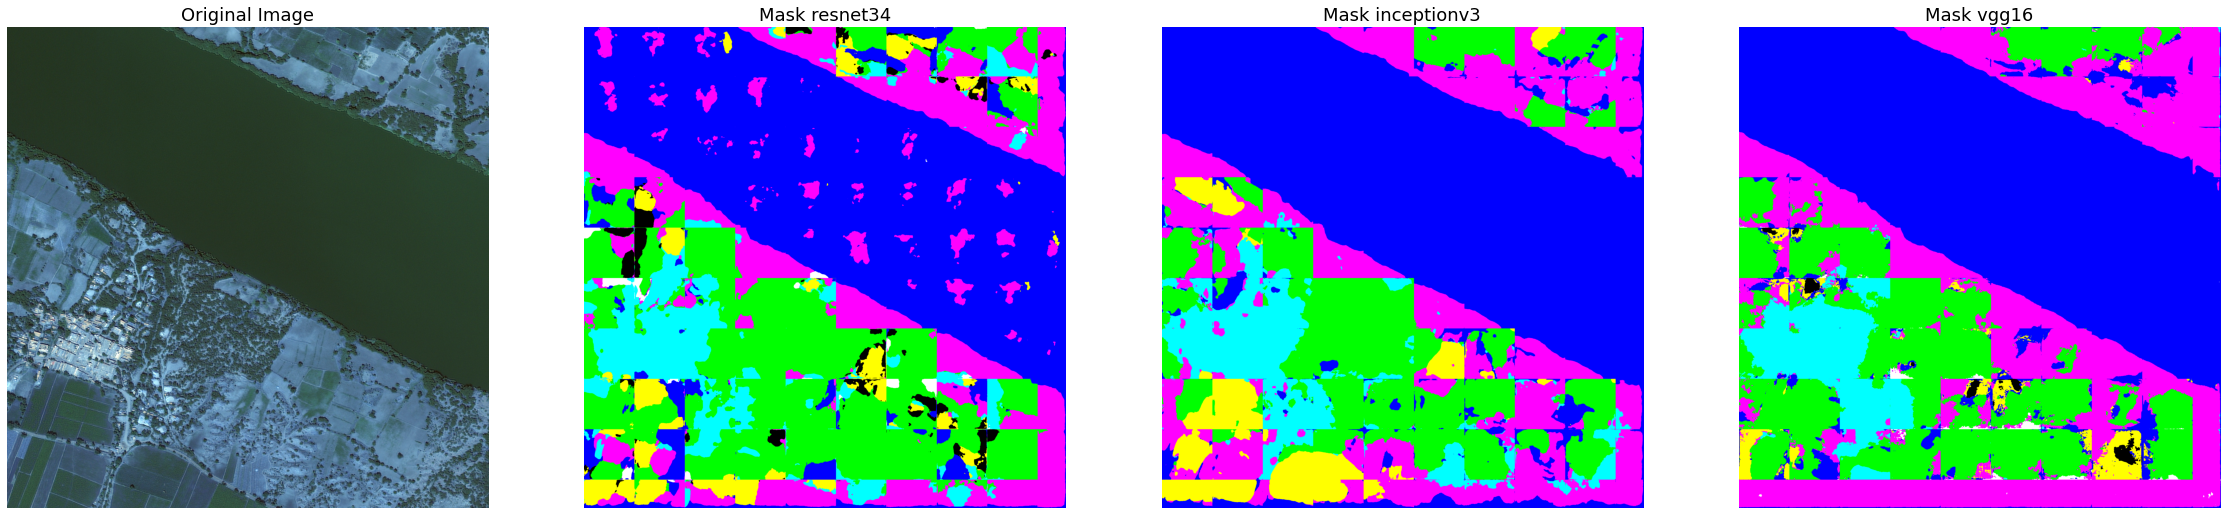

In [ ]:
plot(predicted_masks)